___
# Simulations for local ancestry PRS
___

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import gzip
import multiprocessing as mp

In [2]:
sys.path.insert(0,"/Users/taylorcavazos/repos/Local_Ancestry_PRS/code/")
sys.path.insert(0,"/Users/taylorcavazos/Documents/Prelim_Quals/Aim1")

In [3]:
from sim_out_of_africa import *
from output_true_prs import *
from compute_sum_stats import *
#from output_emp_prs import *

In [4]:
m = 1000
h2 = 0.67
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_sub_CEU_1.95e5.hdf"
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_YRI_5e4_CEU_2e5_chr22.hdf5"

## Simulated admixed individuals

Possible tools for admixture simulations
* [admix-simu (C++ and python)](https://github.com/williamslab/admix-simu)
    - 4 years old
* [bnpsd (R package)](https://cran.r-project.org/web/packages/bnpsd/vignettes/bnpsd.pdf)
    - Came out this year
* [admixture-simulation](https://github.com/slowkoni/admixture-simulation)
    - 2 years old

### a: European and African populations for mating

- 5000 Africans and 5000 Europeans
- Will have difficulty with files much larger because have to write data to vcf and takes up lots of storage

### b: Europeans for training

- 100000 Europeans simulated with out-of-africa model
- In tree structure

### c: African Americans

- Have 4000 admixed individuals
- In future may need larger ~10,000 for doing training
- If I don't use large enough base population these people may be too related

In [ ]:
#tree_all = msprime.load("../data/trees/tree_YRI_5e4_CEU_2e6_chr22.hdf5")
sample_map_all = pd.read_csv("../data/trees/CEU_YRI_sample_map.txt",sep="\t",header=None)

In [ ]:
all_data = np.array(tree_all.samples())

In [ ]:
other_samps = np.delete(all_data,mate_samples)

In [ ]:
tree_other = tree_all.simplify(samples = other_samps, filter_sites=False)

In [ ]:
tree = msprime.load(path_tree)

In [ ]:
sample_map_all = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/CEU_YRI_sample_map.txt",sep="\t",header=None)

In [ ]:
eur_only = sample_map_all[sample_map_all.iloc[:,1]=="CEU"].index

In [ ]:
new_tree = tree.simplify(samples=eur_only,filter_sites=False)

In [ ]:
import itertools

In [ ]:
list(itertools.islice(new_tree.mutations(),10))

In [ ]:
new_tree.mutations()

In [ ]:
new_tree.num_sites

In [ ]:
list(itertools.islice(new_tree.variants(),10))[0]

In [ ]:
list(itertools.islice(new_tree.mutations(),10))

In [ ]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(m,h2),sep="\t",index_col=0)

In [ ]:
prs = sum_stats[sum_stats["p-value"]<5e-8]

In [ ]:
len(prs)

In [ ]:
mut_sites = []
for mut in new_tree.mutations():
    mut_sites.append(mut.site)

In [ ]:
new_prs = prs.loc[np.intersect1d(mut_sites,prs.index)].reset_index()

In [ ]:
new_prs.shape

In [ ]:
sum_stats.loc[62,"OR"]

In [ ]:
float(new_prs.loc[new_prs["var_id"]==62,"OR"])

In [ ]:
len(mut_sites)

In [ ]:
tree.num_sites

In [ ]:
tree.num_mutations

## Get proportion of local ancestry

In [ ]:
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_sub_CEU_1.95e5.hdf"

In [ ]:
n_sites = msprime.load(path_tree).num_sites

In [ ]:
with open("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer.result") as f:
    pbar = tqdm.tqdm(total=n_sites+1)
    ind = 0
    clumped_prs_vars = np.array(open("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/prs_vars_p_5e-8_r2_0.2.txt").read().splitlines()).astype(int)
    for line in f:
        line_spl = line.split("\t")
        if ind == 0:
            sample_haps = line_spl[2:]
            samples = [sample_haps[i].split(".")[0] for i in range(0,len(sample_haps),2)]
            anc_df = pd.DataFrame(columns=samples)
            counts_CEU = np.zeros(len(samples))
            counts_YRI = np.zeros(len(samples))
        elif ind-1 in clumped_prs_vars:
            haplo_anc = np.array(line_spl[2:]).astype(int)
            YRI_arr = haplo_anc-1
            CEU_arr = np.absolute(1-YRI_arr)
            line_counts_CEU = np.add.reduceat(CEU_arr, np.arange(0, len(CEU_arr), 2))
            #SNP=line_spl[0]+"_"+line_spl[1]            
            anc_df.loc[ind-1,:] = line_counts_CEU
            
        ind+=1
        pbar.update(1)
    anc_df.to_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/CEU_counts_prs_vars.txt",sep="\t")

In [ ]:
anc_df

In [5]:
prop_anc = pd.read_csv("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer_PRS.prop.anc",
           sep="\t",index_col=0)

In [ ]:
plt.hist(prop_anc["Prop_CEU"])
plt.show()

In [ ]:
prop_anc[prop_anc["Prop_CEU"]<=0.2].shape

In [ ]:
prop_anc[prop_anc["Prop_CEU"]>=0.8].shape

In [ ]:
prop_anc[(prop_anc["Prop_CEU"]<0.8)&(prop_anc["Prop_CEU"]>0.2)].shape

## Calculate True PRSs for all individuals

In [ ]:
import output_true_prs

Assume same causal variants and effect sizes

Average true PRS over a 100 iterations

In [ ]:
f = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/true_prs/prs_m_1000_h2_0.67.hdf5', 'r')

In [ ]:
f.keys()

In [ ]:
f['labels'][()]

In [ ]:
ceu_anc_prop = [1]*(f['G'].shape[0]-prop_anc.shape[0])+list(prop_anc["Prop_CEU"])

In [ ]:
len(ceu_anc_prop)

In [ ]:
plt.scatter(x=f['G'][()],y=ceu_anc_prop)
plt.xlabel("True Polygenic Risk Score",fontsize=14)
plt.ylabel("Proportion European Ancestry",fontsize=14)
plt.show()

## Select Cases and Controls

In [ ]:
sns.distplot(f['G'][()])
plt.vlines(x=np.percentile(f['G'][()],95),ymin=0,ymax=0.5)
plt.show()

In [ ]:
sns.distplot(G+E)
plt.vlines(x=np.percentile(G+E,95),ymin=0,ymax=0.4)
plt.show()

In [ ]:
sns.distplot(meta_data.loc[eur_train_case,"truePRS"],color="red")
sns.distplot(meta_data.loc[eur_train_control,"truePRS"],color="blue")
plt.show()

In [ ]:
sns.distplot(meta_data.loc[eur_test_case,"truePRS"],color="red")
sns.distplot(meta_data.loc[eur_test_control,"truePRS"],color="blue")
plt.show()

In [ ]:
sns.distplot(meta_data.loc[meta_data.Disease==1,"truePRS"],color="red")
sns.distplot(meta_data.loc[meta_data.Disease==0,"truePRS"],color="blue")
plt.show()

## Perform GWAS with training European samples

#### Calculate MAF EUR

In [ ]:
tree = msprime.load(path_tree)
n_sites = tree.num_sites

#### Perform GWAS

In [ ]:
from statsmodels.stats import multitest

## Calculate Expected PRS for everyone

In [ ]:
from output_emp_prs import *

In [6]:
tree = msprime.load(path_tree)
n_sites = tree.num_sites

In [7]:
bonf_p = 0.05/n_sites

In [8]:
bonf_p

3.807786008518779e-08

In [9]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}_fdr.txt".format(m,h2),sep="\t",index_col=0)

In [10]:
prs_vars = sum_stats[sum_stats["p-value"] < bonf_p].sort_values(by=["p-value"])

In [11]:
prs_vars.shape

(25688, 3)

prs_vars.head(1000).tail(1)

ld_struct = find_ld_sites(tree, [229402],r2_threshold=0.2,num_threads=1)

In [12]:
f = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/emp_prs/emp_prs_m_1000_h2_0.67_LD_ALL.hdf5', 'r')

In [13]:
f.keys()

<KeysViewHDF5 ['X', 'labels']>

In [14]:
f['labels'][()]

array([b'msp_0', b'msp_1', b'msp_2', ..., b'50c36e0f', b'35048bc5',
       b'1cb4b81d'], dtype='|S10')

In [15]:
emp = f['X'][()]
emp_Z = (emp - np.mean(emp))/np.std(emp)

In [16]:
f_LA = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/emp_prs/emp_prs_m_1000_h2_0.67_LD_ADMIX_UNWEIGHT.hdf5', 'r')
emp_LA = f_LA['X'][()]
emp_Z_LA = (emp_LA - np.mean(emp_LA))/np.std(emp_LA)
LA_only_labels = f_LA['labels'][()].astype(str)

In [17]:
t = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/true_prs/prs_m_1000_h2_0.67.hdf5', 'r')

In [18]:
true = t['Zx'][()]

In [19]:
t['labels'][()]

array([b'msp_0', b'msp_1', b'msp_2', ..., b'50c36e0f', b'35048bc5',
       b'1cb4b81d'], dtype='|S10')

In [20]:
emp.shape

(199000,)

In [21]:
true.shape

(199000,)

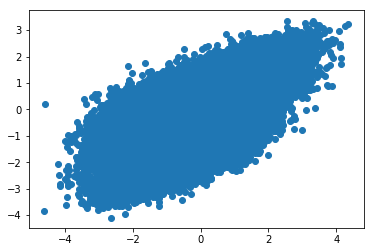

In [22]:
plt.scatter(true,emp_Z)
plt.show()

In [23]:
train_test = h5py.File("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/train_test_CEU_m_1000_h2_0.67.hdf5")

In [24]:
train_test.keys()

<KeysViewHDF5 ['test_cases', 'test_controls', 'train_cases', 'train_controls']>

In [25]:
training = np.append(train_test["train_controls"][()],train_test["train_cases"][()])
testing = np.append(train_test["test_controls"][()],train_test["test_cases"][()])

In [26]:
len(train_test["train_controls"][()])

90000

In [27]:
len(train_test["train_cases"][()])

9000

In [28]:
training_msp = ["msp_"+str(train) for train in training]
testing_msp = ["msp_"+str(test) for test in testing]

In [29]:
labels = t['labels'][()].astype(str)

In [30]:
label_inds = pd.DataFrame(np.arange(0,len(labels)),index = labels)
LA_label_inds = pd.DataFrame(np.arange(0,len(LA_only_labels)),index = LA_only_labels)

In [31]:
train_inds = label_inds.loc[training_msp,0].values
test_inds = label_inds.loc[testing_msp,0].values

In [32]:
admix = label_inds.loc[prop_anc.index,0].values
LA_admix = LA_label_inds.loc[prop_anc.index,0].values

In [33]:
low_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]>0.8].index,0].values
mid1 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.2)&(prop_anc["Prop_CEU"]<=0.4)].index,0].values
mid2 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.4)&(prop_anc["Prop_CEU"]<=0.6)].index,0].values
mid3 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.6)&(prop_anc["Prop_CEU"]<=0.8)].index,0].values
high_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<=0.2].index,0].values

In [34]:
LA_low_admix = LA_label_inds.loc[prop_anc[prop_anc["Prop_CEU"]>0.8].index,0].values
LA_mid1 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.2)&(prop_anc["Prop_CEU"]<=0.4)].index,0].values
LA_mid2 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.4)&(prop_anc["Prop_CEU"]<=0.6)].index,0].values
LA_mid3 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.6)&(prop_anc["Prop_CEU"]<=0.8)].index,0].values
LA_high_admix = LA_label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<=0.2].index,0].values

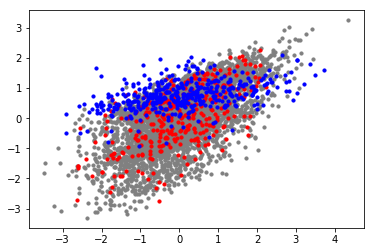

In [35]:
plt.scatter(true[test_inds],emp_Z[test_inds],s=10,color="gray")
plt.scatter(true[low_admix],emp_Z[low_admix],color="red",s=10)
#plt.scatter(true[low_admix],emp_Z_LA[LA_low_admix],color="blue",s=10)
plt.scatter(true[high_admix],emp_Z[high_admix],color="blue",s=10)
#plt.scatter(true[high_admix],emp_Z_LA[LA_high_admix],color="blue",s=10)
#plt.scatter(true[mid_admix],emp_Z[mid_admix],color="orange",s=10)

plt.show()

In [36]:
stats.pearsonr(true[test_inds],emp_Z[test_inds])

(0.6452842291810224, 0.0)

CEU > 0.8

In [37]:
len(low_admix)

330

In [38]:
stats.pearsonr(true[low_admix],emp_Z[low_admix])

(0.6063464890183036, 1.6408427561048004e-34)

In [39]:
stats.pearsonr(true[low_admix],emp_Z_LA[LA_low_admix])

(0.603608653479665, 3.882837347694644e-34)

CEU <= 0.2

In [40]:
len(high_admix)


407

In [41]:
stats.pearsonr(true[high_admix],emp_Z[high_admix])

(0.43211061112848165, 6.046213936725284e-20)

In [42]:
stats.pearsonr(true[high_admix],emp_Z_LA[LA_high_admix])

(0.19180892385354167, 9.864022778799084e-05)

0.2 < CEU <= 0.4

In [ ]:
stats.pearsonr(true[mid1],emp_Z[mid1])

0.4 < CEU <= 0.6

In [ ]:
stats.pearsonr(true[mid2],emp_Z[mid2])

0.6 < CEU <= 0.8

In [ ]:
stats.pearsonr(true[mid3],emp_Z[mid3])

In [ ]:
low_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<0.2].index,0].values

In [ ]:
admix = label_inds.loc[prop_anc.index,0].values

### a: Using European GWAS

### b: Using Local-Ancestry Specific Approach (relies on significant SNPs from European GWAS)

## Calculate AUCs and compare between approaches

In [43]:
clumped_prs_vars = np.array(open("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/prs_vars_p_5e-8_r2_0.2.txt").read().splitlines()).astype(int)

In [44]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(m,h2),sep="\t",index_col=0)

In [45]:
prs_vars = sum_stats.loc[clumped_prs_vars,:]

In [46]:
sum_stats.loc[1488,:]

OR         1.440465e+00
p-value    2.104703e-30
Name: 1488, dtype: float64

In [56]:
set(causal_stats.index).intersection(set(prs_vars.index))

{441201,
 470089,
 516047,
 787859,
 856140,
 866645,
 1089872,
 1104316,
 1116134,
 1154214,
 1254009,
 1271079,
 1285523}

In [51]:
causal_stats = sum_stats.reindex(causal_inds).dropna(how="all")
causal_stats[causal_stats["p-value"]<5e-8]

,OR,p-value
var_id,,
56463,1.580547,2.570926e-44
86664,0.495890,1.558270e-205
118178,1.224101,3.438086e-13
123431,1.440465,2.104703e-30
147067,0.615189,1.888005e-106
152319,1.470103,1.168410e-36
174642,1.440465,2.104703e-30
240297,1.987021,7.618088e-71
266559,1.470103,1.168410e-36


In [52]:
prs_vars.sort_index()

,OR,p-value
var_id,,
62,0.567920,4.435143e-11
91,0.528590,1.392931e-58
1488,1.440465,2.104703e-30
1665,0.629757,3.619063e-10
1677,0.402226,9.177612e-20
2431,0.495890,1.558270e-205
3032,0.527571,9.919147e-13
3367,0.539539,1.032609e-24
3569,1.149806,2.810854e-10


In [53]:
vcf_file = "/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer.query.vcf"

In [54]:
afs = []
with open(vcf_file) as f:
    ind=0
    for line in f:
        if line[0] != "#":
            if ind in clumped_prs_vars:
                data = line.split("\t")[9:]
                genotype = np.array([np.array(hap.split("|")).astype(int).sum() for hap in data])
                af = genotype.sum()/(2*4000)
                afs.append(af)
            ind+=1

In [61]:
(np.array(afs)<0.01).sum()

189

In [ ]:
0.615194/0.244875

In [ ]:
np.log(0.567920)/0.000625

In [ ]:
np.log(0.567920)

In [50]:
causal_inds = np.linspace(0, n_sites, m, dtype=int,endpoint=False)

In [ ]:
causal_inds